In [100]:
import numpy as np
from numpy.random import default_rng
from scipy.integrate import odeint
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
import time

In [101]:
# Define classes
class Agent:
    def __init__(self, opinion, activity):
        self.x=opinion
        self.a=activity
        
    def setOpinion(self, opinion):
        self.x=opinion   
        
    def getOpinion(self):
        return self.x
    
    def setActivity(self, activity):
        self.a=activity
        
class Model:
    def __init__(self, N):
        
        x = np.linspace(-1,1,N)
        PowerDistribution = PowerLaw(a=epsilon)
        a = PowerDistribution.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))
            
    def getNetwork(self):
        return self.network
    
    def getAllOpinions(self):
        allOpinions = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allOpinions[i] = self.network[i].getOpinion()
        return allOpinions
    
    def updateAllOpinions(self, newOpinions):
        if len(self.network) == len(newOpinions):
            for i in range(len(self.network)):
                self.network[i].setOpinion(newOpinions[i])

class PowerLaw(rv_continuous):
    """Activitiy sampling distribution identical to Baumann et al.
    It models the intuitive assumption, that by far most people
    are hardly posting on social media, and even less people being
    very active. 
    

    For Reference, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous"""
    # define probability distribution as the paper's "F(a)"
    def _pdf(self, x):
        return ((1-gamma)/(1-epsilon**(1-gamma)))*x**(-1*gamma)


In [102]:
# Define methods

# Implement differential eq. 'dx/dt = [...]' as 'f(t) = [...]' 
def diffEq(x, t, alpha, K):
    sol = np.zeros(N)
    for i in range(N):
        sum_tmp = 0
        for j in range(N):
            sum_tmp = sum_tmp+A[i][j]*np.tanh(alpha*x[j])
        sol[i] = -x[i]+K*sum_tmp
    return sol

def calculateProbabilities(i, j, x, beta):
    sum_tmp = 0
    for j_tmp in range(len(x)):
        if x[i] != x[j_tmp]:
            sum_tmp = sum_tmp+abs(x[i]-x[j_tmp])**(-beta)
    return (abs(x[i]-x[j])**(-beta))/sum_tmp

def generateContactMatrix(x, beta, m, r):
    rng = default_rng()
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                A[i][j] = calculateProbabilities(i,j, x, beta)
                if m*A[i][j] > rng.random():
                    A[i][j] = 1
                    # Füge recipr. contacting ein:
                    if r > rng.random():
                        A[j][i] = 1
    return A

In [110]:
# Define fixed parameters
t_current = 0
tMax = 10
dt = 0.01
N = 200
K=3
# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([0.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[0]
beta_current = betas[0]

# Fixed activity-driving (AD) parameters
m = 10
epsilon = 0.01
gamma = 2.1
r = 0.5


model = Model(N)
opinionStorage = model.getAllOpinions()

In [111]:
execution_start_time = time.time()
print('---\nModel started\n---\n')

# Integrate dynamics with 4th order Runge-Kutta (RK4)

while t_current+dt < tMax:
    t_current = t_current + dt
    print(round(t_current*100/tMax,2),'\t%')
    currentOpinions = model.getAllOpinions()
    t_RK4 = np.linspace(t_current-dt, t_current, 2)
    A = generateContactMatrix(currentOpinions, beta_current, m, r)
    solODE = odeint(diffEq, currentOpinions, t_RK4, args=(alpha_current, K))
    
    # Update and store new opinions in agents and storage array
    newOpinions = solODE[-1]
    model.updateAllOpinions(newOpinions)
    opinionStorage = np.vstack([opinionStorage, newOpinions])

print('\n---\nModel finished\n---')
execution_end_time = time.time()
print('\n---\nTime needed:\t',execution_end_time-execution_start_time,'\n---')

---
Model started
---

0.1 	%
0.2 	%
0.3 	%
0.4 	%
0.5 	%
0.6 	%
0.7 	%
0.8 	%
0.9 	%
1.0 	%
1.1 	%
1.2 	%
1.3 	%
1.4 	%
1.5 	%
1.6 	%
1.7 	%
1.8 	%
1.9 	%
2.0 	%
2.1 	%
2.2 	%
2.3 	%
2.4 	%
2.5 	%
2.6 	%
2.7 	%
2.8 	%
2.9 	%
3.0 	%
3.1 	%
3.2 	%
3.3 	%
3.4 	%
3.5 	%
3.6 	%
3.7 	%
3.8 	%
3.9 	%
4.0 	%
4.1 	%
4.2 	%
4.3 	%
4.4 	%
4.5 	%
4.6 	%
4.7 	%
4.8 	%
4.9 	%
5.0 	%
5.1 	%
5.2 	%
5.3 	%
5.4 	%
5.5 	%
5.6 	%
5.7 	%
5.8 	%
5.9 	%
6.0 	%
6.1 	%
6.2 	%
6.3 	%
6.4 	%
6.5 	%
6.6 	%
6.7 	%
6.8 	%
6.9 	%
7.0 	%
7.1 	%
7.2 	%
7.3 	%
7.4 	%
7.5 	%
7.6 	%
7.7 	%
7.8 	%
7.9 	%
8.0 	%
8.1 	%
8.2 	%
8.3 	%
8.4 	%
8.5 	%
8.6 	%
8.7 	%
8.8 	%
8.9 	%
9.0 	%
9.1 	%
9.2 	%
9.3 	%
9.4 	%
9.5 	%
9.6 	%
9.7 	%
9.8 	%
9.9 	%
10.0 	%
10.1 	%
10.2 	%
10.3 	%
10.4 	%
10.5 	%
10.6 	%
10.7 	%
10.8 	%
10.9 	%
11.0 	%
11.1 	%
11.2 	%
11.3 	%
11.4 	%
11.5 	%
11.6 	%
11.7 	%
11.8 	%
11.9 	%
12.0 	%
12.1 	%
12.2 	%
12.3 	%
12.4 	%
12.5 	%
12.6 	%
12.7 	%
12.8 	%
12.9 	%
13.0 	%
13.1 	%
13.2 	%
13.3 	%
13.4 	%
13.5

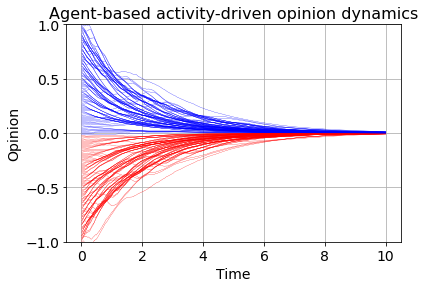

In [122]:
# Plot results:

# Globally change font size for Matplotlib plots
plt.rcParams.update({'font.size': 14})

# Get time values for plotting out of storage array information
time_finish = len(opinionStorage)*dt
time_0 = 0
times = np.arange(time_0, time_finish, dt)

# Plot each agent via looping over storage array
for i in range(len(opinionStorage.T)):
    # In case the last value of agent i is negative, the graph color will be changed to red 
    if opinionStorage.T[i][-1] < 0:
        color = 'r'
    else:
        color ='b'   
    plt.plot(times, opinionStorage.T[i], color, linewidth=.25)

plt.xlabel('Time')
plt.ylabel('Opinion')
plt.title('Agent-based activity-driven opinion dynamics', size=16)
plt.grid()
plt.ylim([-1, 1])
#plt.xticks([0, 5, 10])
#plt.yticks([-5, 0, 5])

# Uncomment if you do want to save the figure:
plot_name = 'Plot--N='+str(N)+'--alpha='+str(alpha_current)+'--beta='+str(beta_current)+'.png'
plt.savefig(plot_name)
plt.show()
